In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier    
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture

from sklearn.gaussian_process.kernels import RBF

In [4]:
def series_to_supervised(in_data, tar_data, n_in=1, dropnan=True, target_dep=False, maxlag=0):
    """
    Transformation into a training sample taking into account the lag
     : param in_data: Input fields
     : param tar_data: Output field (single)
     : param n_in: Lag shift
     : param dropnan: Do destroy empty lines
     : param target_dep: Whether to take into account the lag of the input field If taken into account, the input will start with lag 1
     : return: Training sample. The last field is the source
    """
    
    if maxlag>=0:
        n_in, maxlag = maxlag, n_in
        
    n_vars = in_data.shape[1]
    cols, names = list(), list()

    if target_dep:
        i_start = 1
    else:
        i_start = 0
    i_start += maxlag
    for i in range(i_start, n_in + 1):
        cols.append(in_data.shift(i))
        names += [('%s(t-%d)' % (in_data.columns[j], i)) for j in range(n_vars)]

    if target_dep:
        for i in range(n_in, -1, -1):
            cols.append(tar_data.shift(i))
            names += [('%s(t-%d)' % (tar_data.name, i))]
    else:
        # put it all together
        cols.append(tar_data)
        names.append(tar_data.name)
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def my_load(lag, maxlag):
    ex = pd.read_excel('Peaks.xlsx', sheet_name = None)
    df = pd.DataFrame()
    for i, s in ex.items():
        df_tmp = pd.DataFrame(s)
        # df_tmp = df_tmp[['> 10 MeV', '> 30 MeV', '38-53', '175-315', '310-580', 'PROTON DENSITY', 'BULK SPEED',
        #    'ION TEMPERATURE', '10.7 cm Radio Flux',
        #    'days from the beginning of the flood']]
        col = df_tmp.columns
        x, y = df_tmp[col[1:-1]], df_tmp[col[-1]]
        df_tmp = series_to_supervised(x, y, lag, maxlag=maxlag)   
        df = df.append(df_tmp)
    # Знищення всіх колонок, яких пропусків більше ніж 10%
    for i, c in enumerate(df.columns):
        x=df[c]
        if x.isna().sum() > 0.1*len(df):                    
                del df[c]
    df = df.dropna()
    df[df.columns[:]] = df[df.columns[:]].astype('bool')

    return df

In [6]:
def my_score(estimator, X, y):
    yhat = estimator.predict(X)
    n = 0
    N = y.values.sum()
    for i, f in enumerate(y.values):
        if f and yhat[i]:
            n+=1
    return n/N

In [7]:
def my_acc(estimator, lag, scoring):
    #df = my_load(lag, 9) #forecast
    df = my_load(0, lag) #

    col = df.columns
    x, y = df[col[:-1]], df[col[-1]]
    # metrix = ['accuracy', 'precision', 'recall','f1', my_score]
    # metrix_name = ['accuracy', 'precision', 'recall','f1', 'Flood forrecast']
    # print(x)
    # print(y)
    
    scores = cross_val_score(estimator, x, y, scoring=scoring, cv=3)
    # print("Accuracy cross: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=28)
    estimator.fit(x_train, y_train)
    accuracy_train = my_score(estimator, x_train, y_train, scoring)
    accuracy_test = my_score(estimator, x_test, y_test, scoring) 

    # print('Accuracy train %.2f' % (accuracy*100))
    return accuracy_train, accuracy_test, scores.mean()

In [8]:
def my_score(estimator, x, y, scoring):
    y_res = estimator.predict(x)
    if scoring =='f1':
            accuracy = f1_score(y_res, y)
    elif scoring =='precision':           
            accuracy = precision_score(y_res, y)   
    elif scoring =='recall':    
            accuracy = recall_score(y_res, y)
    else:
            accuracy = accuracy_score(y_res, y)
    return accuracy

In [9]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
def test_lag(clf, scoring):
    print("***** Test", scoring, "******")
    df_tr = pd.DataFrame()
    df_ts = pd.DataFrame()
    df_cv = pd.DataFrame()
    for classif in clf:
        print(classif)
        res_tr = {}
        res_tr['classifier'] = [str(classif)]
        res_ts = {}
        res_ts['classifier'] = [str(classif)]
        res_cv = {}
        res_cv['classifier'] = [str(classif)]   
        for lag in range(10):
            # print("Lag: ", lag)
            tr, ts, tcv = my_acc(classif, lag, scoring)
            res_tr['Lag '+str(lag)] = [tr]
            res_ts['Lag '+str(lag)] = [ts]
            res_cv['Lag '+str(lag)] = [tcv]

        df_tr = df_tr.append(pd.DataFrame(res_tr))
        df_ts = df_ts.append(pd.DataFrame(res_ts))
        df_cv = df_cv.append(pd.DataFrame(res_cv))


    df_tr = df_tr.set_index('classifier')
    df_ts = df_ts.set_index('classifier')
    df_cv = df_cv.set_index('classifier')
    # print(df_tr)
    # print(df_ts)
    # print(df_cv)
    with pd.ExcelWriter(str(scoring)+'.xlsx') as writer:  
        df_tr.to_excel(writer, sheet_name='Train DataSet')        
        df_ts.to_excel(writer, sheet_name='Test DataSet')
        df_cv.to_excel(writer, sheet_name='CrossValidation DataSet')

In [ ]:
scoring = 'recall'
clf = [DecisionTreeClassifier()]
metrix = ['accuracy', 'precision', 'recall', 'f1']



clf = [DecisionTreeClassifier(), 
       LogisticRegression(random_state=1), 
       QuadraticDiscriminantAnalysis(), 
       GaussianNB(),
       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
       SVC(decision_function_shape='ovo'),
       SGDClassifier(max_iter=1000, tol=1e-3),
       MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,10), random_state=1),
       ExtraTreesClassifier(n_estimators=100, random_state=0),
       KNeighborsClassifier(n_neighbors=3),
       OutputCodeClassifier(estimator=RandomForestClassifier(random_state=0),random_state=0),
       OneVsOneClassifier(LinearSVC(random_state=0)),
       OneVsRestClassifier(SVC()),
       RidgeClassifier(),
       PassiveAggressiveClassifier(max_iter=1000, random_state=0, tol=1e-3),
       GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=0),
       BernoulliNB(),
       LabelPropagation(),
       LabelSpreading(),
       LinearDiscriminantAnalysis(),
        LinearSVC(random_state=0, tol=1e-5),
       MultinomialNB(),
       NearestCentroid(),
       Perceptron(tol=1e-3, random_state=0),
       SVC(gamma='auto'),
       AdaBoostClassifier(n_estimators=100, random_state=0),
       GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
       BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0),
      ]

est = [(str(est), est) for est in clf]

eclf = [VotingClassifier(
     estimators=est,
     voting='hard')]

# test_lag(clf + eclf, scoring)

for scoring in metrix:
    test_lag(clf + eclf, scoring)


***** Test accuracy ******
DecisionTreeClassifier()
LogisticRegression(random_state=1)
QuadraticDiscriminantAnalysis()
GaussianNB()


In [ ]:
df = my_load(0, 9)

# pd.DataFrame(res_tr)
df

In [14]:
df.to_csv('Dataset.csv')

In [15]:
pd.set_option('display.max_columns', 12)
df

,Z2(t-0),Z2A(t-0),Z3(t-0),DE1(t-0),DE2(t-0),DE3(t-0),...,P7p(t-9),P8p(t-9),p_speed(t-9),10.7 cm Radio Flux(t-9),precipitations(t-9),days from the beginning of the flood
9,True,False,False,True,False,False,...,False,False,False,False,False,False
10,False,False,True,False,False,False,...,False,False,False,False,False,False
11,False,True,False,False,True,False,...,False,True,True,False,True,False
12,False,False,False,False,False,False,...,False,False,False,True,False,True
9,True,True,False,False,False,False,...,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,False,False,False,False,False,False,...,True,True,False,False,False,True
9,False,True,True,True,True,True,...,False,False,False,False,False,False
10,True,False,False,False,False,False,...,False,False,False,False,False,False
11,False,False,False,False,False,False,...,False,False,False,False,False,False


In [16]:
col = df.columns
x, y = df[col[:-1]], df[col[-1]]


In [17]:
clf = DecisionTreeClassifier()
# clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
scores = cross_val_score(clf, x, y, scoring='recall', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'DecisionTreeClassifier'))
clf.fit(x, y)

Accuracy: 0.81 (+/- 0.07) [DecisionTreeClassifier]


DecisionTreeClassifier()

In [18]:
y.unique()

array([False,  True])

In [19]:
import graphviz
dot_data = tree.export_graphviz(clf,
               feature_names = x.columns, 
               class_names = ['No','Flood'],
                                filled=True, 
                                rounded=True)

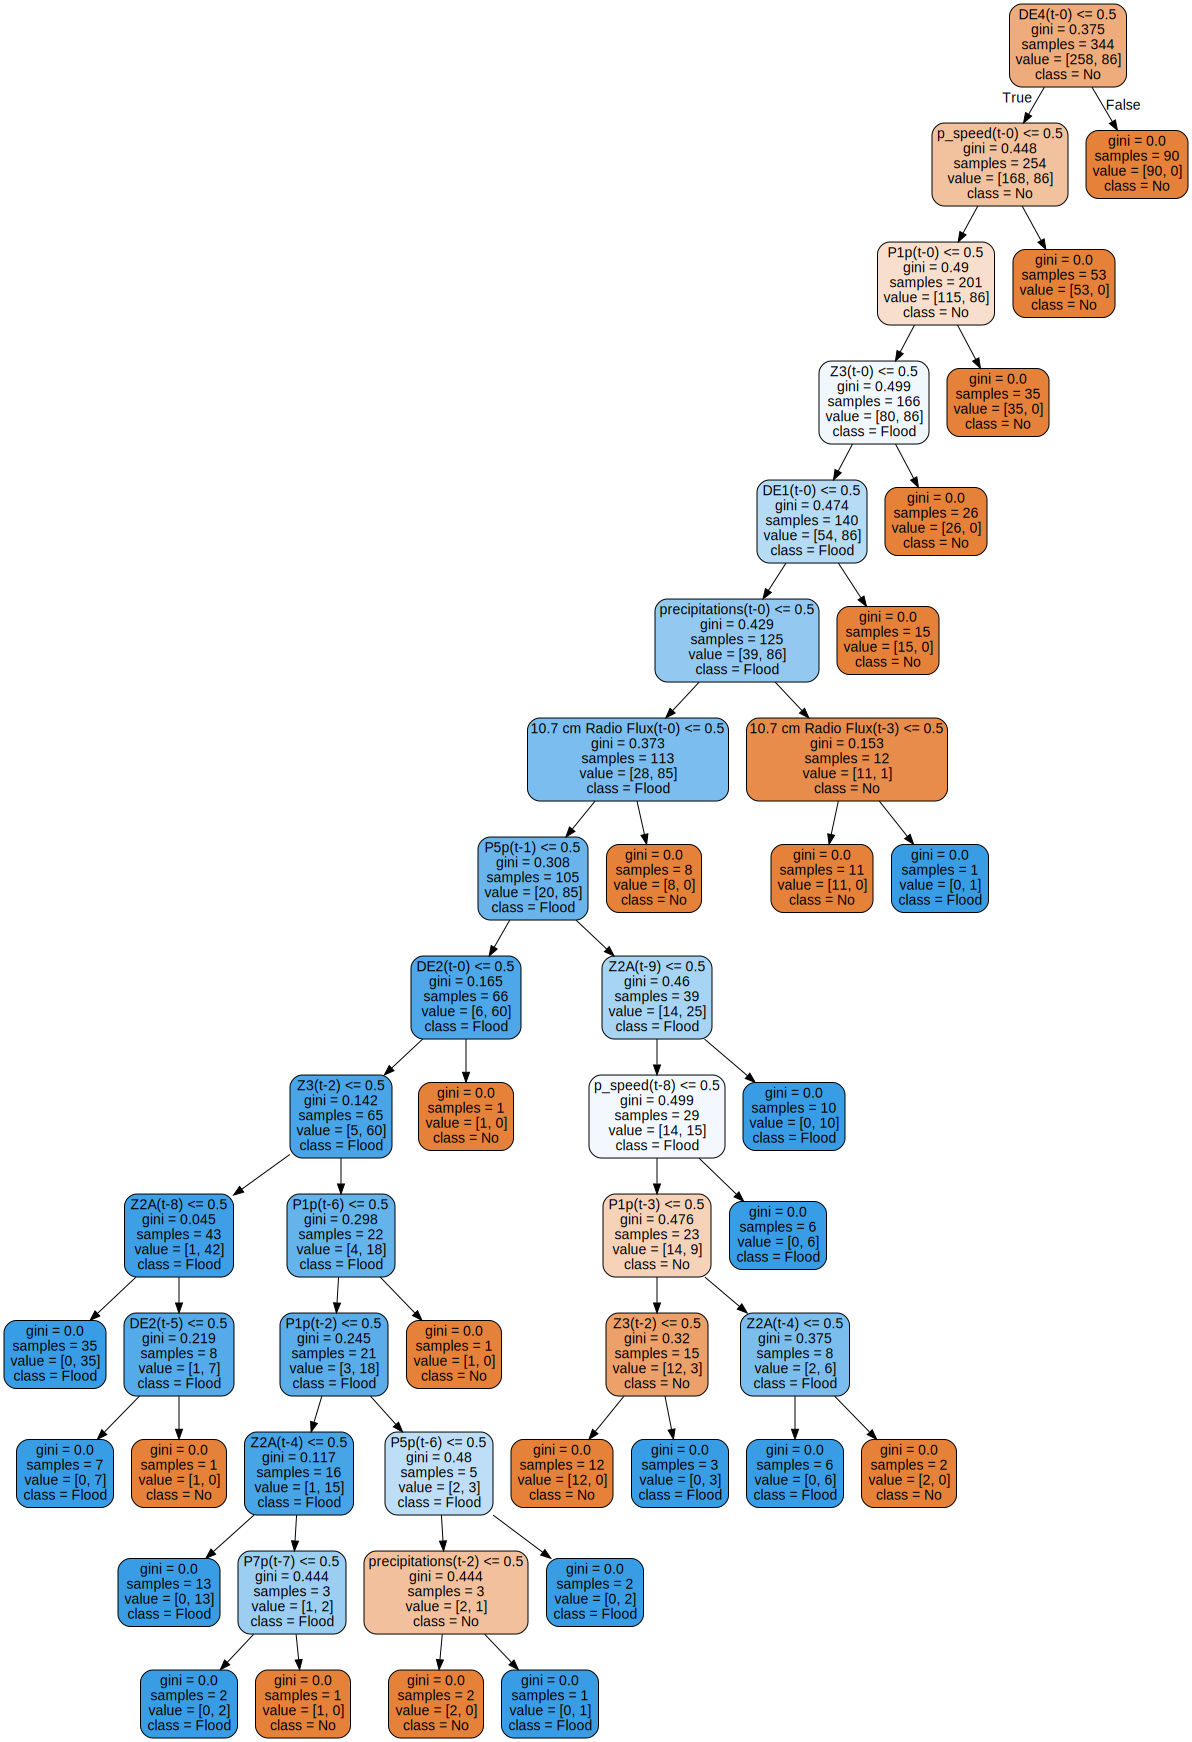

In [20]:
graph = graphviz.Source(dot_data, format="png") 
graph

In [21]:
graph.render("decision_tree_graphivz_9-9")

'decision_tree_graphivz_9-9.png'

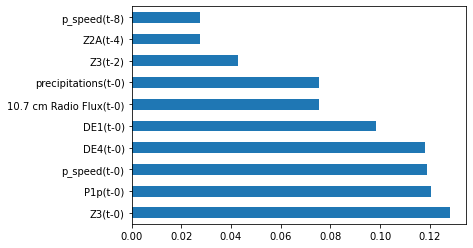

In [22]:
feat_importances = pd.Series(clf.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [23]:
feat_importances.nlargest(10)

Z3(t-0)                    0.128285
P1p(t-0)                   0.120282
p_speed(t-0)               0.119037
DE4(t-0)                   0.118110
DE1(t-0)                   0.098286
10.7 cm Radio Flux(t-0)    0.075527
precipitations(t-0)        0.075246
Z3(t-2)                    0.042882
Z2A(t-4)                   0.027455
p_speed(t-8)               0.027335
dtype: float64